In [10]:
import os
import cv2 as cv
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt  

In [11]:
# Define paths
BASE_DIR = r"/home/mynah/Downloads/Hindi ocr(1)/Hindi ocr/Dataset"
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

# Define image properties
IMG_HEIGHT = 48
IMG_WIDTH = 128
CHANNELS = 1
TIME_STEPS = IMG_WIDTH // 4  # 32

# Load labels
train_labels_df = pd.read_csv(os.path.join(TRAIN_DIR, "train_labels.csv"), sep=",", quotechar='"', encoding="utf-8")
test_labels_df = pd.read_csv(os.path.join(TEST_DIR, "labels.csv"), sep=",", quotechar='"', encoding="utf-8")

# Extract unique characters
all_labels = ''.join(train_labels_df["Label"].tolist() + test_labels_df["Label"].tolist())
unique_chars = sorted(set(all_labels))
unique_chars.append('[BLANK]')  # CTC blank token
char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}
NUM_CLASSES = len(unique_chars)
print(all_labels)
print(NUM_CLASSES)
print(unique_chars)

# Max label length
MAX_LABEL_LEN = max(train_labels_df["Label"].str.len().max(), test_labels_df["Label"].str.len().max())
print(MAX_LABEL_LEN)

# Function to encode labels
BLANK_IDX = char_to_idx['[BLANK]']
def encode_label(label):
    return [char_to_idx[char] for char in label] + [BLANK_IDX] * (MAX_LABEL_LEN - len(label))

# Custom Dataset class
class OCRDataset(Dataset):
    def __init__(self, image_dir, labels_df):
        self.image_dir = image_dir
        self.labels_df = labels_df
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        row = self.labels_df.iloc[idx]
        img_path = os.path.join(self.image_dir, row["Filename"])
        label = row["Label"]
        
        img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Warning: Image {img_path} not found.")
            return None
            
        h, w = img.shape
        if w < IMG_WIDTH:
            img = np.pad(img, ((0, 0), (0, IMG_WIDTH - w)), mode='constant', constant_values=255)
        elif w > IMG_WIDTH:
            img = cv.resize(img, (IMG_WIDTH, h))
        img = cv.resize(img, (IMG_WIDTH, IMG_HEIGHT))
        img = img.astype("float32") / 255.0
        img = torch.FloatTensor(img).unsqueeze(0)  # Add channel dimension
        
        encoded_label = encode_label(label)
        label_tensor = torch.LongTensor(encoded_label)
        label_length = torch.tensor([len(label)], dtype=torch.long)
        input_length = torch.tensor([TIME_STEPS], dtype=torch.long)
        
        return {
            "images": img,
            "labels": label_tensor,
            "input_length": input_length,
            "label_length": label_length,
            "true_label": label  # Store the original label for comparison
        }



फलकाटतेहैंतोवहहिंसानहीं?फिरशाकाहारीमांसाहारीसेकिसथी।इससेक्याप्रयोजन?परायेबच्चेपरायेहीहोतेहैं।बच्चोंपरकधीकाममेंकितनीभीव्यस्तक्योंनहो,उसेसमाचारपत्रदेनाहीहै?देपाते?घटनाकाबहुतहीबुराप्रभावपड़ा।वास्तवमेंमुझमेंसमताकाभावचलजायेगान?”मामाजीनेमेरीपढ़ाईकीव्यवस्थाकी।पिताजीकायहव्यवहारनेभीयहीफैसलासुनाया।इसकेअतिरिक्तनाबालिगमेरेसौतेलेभाइयोंमेराभाग्यहीखोटाथा।एकवर्षबीते,नबीते,मेरीपढ़ाईमेंकाशमिलतातोउससेहाथधोबैठनामूर्खताहोगी।पढ़ाईकेनामपररातकोउसनेजितनेआदरसेबातेंकींथीं,वहआदरआजउसकीबातोंनिकलेतोमैंअपनासिरउठाकरकैसेधूमसकती?आत्म-हत्याहीएकइतनेमेंमामाजीआये।लज्जितहोतीहुईउठखड़ीहुई।उनकेपीछेस्मृति-पटलपरनाचनेलगीं।श्यामारावकोदेखकरमेरेमनमेंकोईनहींथा।वहपूर्णताकोप्राप्तनहींकरचुकीथी।मैंसोचतीरहीकिअवकासकीप्रतीक्षाकरनीचाहिए।अवकाशकेमिलनेपरउसकापूरा-शादीकरनेकेलिएकोईनकोईकन्यातैयारहोजाती।महिलाओंकीविवाहकेलिएस्वीकृतिनहींदेते।इसविषयपरज्यादाबहसकरनाहै?अविवाहितस्त्रियाँपढ़सकतीं।नौकरीजोकरनाचाहतीहैं,वेभीबचकररहनेलगतेहैं,वेमहात्मामानेजातेहैंश्यामारावभीउनकीश्रेणी"किससे?"-मोहनकुमारनेचिढ़तेहुएपूछा।नहींपड़ता।""भविष्यमेंसावधानीसेव्यवहारकरो।झूठबोलकरकिसीकोबहु

In [12]:
# Load data
train_dataset = OCRDataset(TRAIN_DIR, train_labels_df)
test_dataset = OCRDataset(TEST_DIR, test_labels_df)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

# CRNN Model
class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        
        # CNN layers
        self.cnn = nn.Sequential(
            nn.Conv2d(CHANNELS, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        
        # RNN layers
        self.rnn = nn.Sequential(
            nn.LSTM(128 * (IMG_HEIGHT // 4), 256, bidirectional=True, dropout=0.3, batch_first=True)
        )
        
        # Fully connected layer
        self.fc = nn.Linear(512, NUM_CLASSES)  # 512 = 256 * 2 (bidirectional)
        
    def forward(self, x):
        # CNN
        x = self.cnn(x)
        # Reshape for RNN
        batch_size = x.size(0)
        x = x.permute(0, 3, 1, 2)  # (batch, channels, height, width) -> (batch, width, height, channels)
        x = x.reshape(batch_size, TIME_STEPS, -1)
        # RNN
        x, _ = self.rnn(x)
        # FC
        x = self.fc(x)
        return x


In [13]:


def train_model(model, train_loader, test_loader, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CTCLoss(blank=BLANK_IDX, zero_infinity=True)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            if batch is None:
                continue

            images = batch["images"].to(device)
            labels = batch["labels"].to(device)
            input_lengths = batch["input_length"].to(device)
            label_lengths = batch["label_length"].to(device)

            optimizer.zero_grad()
            outputs = model(images)
            outputs = outputs.log_softmax(2)
            outputs = outputs.permute(1, 0, 2)

            loss = criterion(outputs, labels, input_lengths.squeeze(), label_lengths.squeeze())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in test_loader:
                if batch is None:
                    continue

                images = batch["images"].to(device)
                labels = batch["labels"].to(device)
                input_lengths = batch["input_length"].to(device)
                label_lengths = batch["label_length"].to(device)

                outputs = model(images)
                outputs = outputs.log_softmax(2)
                outputs = outputs.permute(1, 0, 2)
                val_loss += criterion(outputs, labels, input_lengths.squeeze(), label_lengths.squeeze()).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(test_loader)

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.title("Loss Curves")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.savefig("loss_curve.png")
    plt.show()

Epoch 1/20:   0%|          | 0/4986 [00:00<?, ?it/s]

Epoch 1/20: 100%|██████████| 4986/4986 [01:03<00:00, 78.58it/s]


Epoch 1: Train Loss: 0.8845, Val Loss: 0.1913


Epoch 2/20: 100%|██████████| 4986/4986 [01:02<00:00, 80.07it/s]


Epoch 2: Train Loss: 0.1144, Val Loss: 0.1297


Epoch 3/20: 100%|██████████| 4986/4986 [01:02<00:00, 79.83it/s]


Epoch 3: Train Loss: 0.0628, Val Loss: 0.0661


Epoch 4/20: 100%|██████████| 4986/4986 [01:02<00:00, 79.70it/s]


Epoch 4: Train Loss: 0.0413, Val Loss: 0.0619


Epoch 5/20: 100%|██████████| 4986/4986 [01:03<00:00, 78.80it/s]


Epoch 5: Train Loss: 0.0301, Val Loss: 0.0551


Epoch 6/20: 100%|██████████| 4986/4986 [01:03<00:00, 78.19it/s]


Epoch 6: Train Loss: 0.0228, Val Loss: 0.0615


Epoch 7/20: 100%|██████████| 4986/4986 [01:03<00:00, 78.41it/s]


Epoch 7: Train Loss: 0.0189, Val Loss: 0.0669


Epoch 8/20: 100%|██████████| 4986/4986 [01:02<00:00, 80.31it/s]


Epoch 8: Train Loss: 0.0145, Val Loss: 0.0550


Epoch 9/20: 100%|██████████| 4986/4986 [01:01<00:00, 80.80it/s]


Epoch 9: Train Loss: 0.0127, Val Loss: 0.0546


Epoch 10/20: 100%|██████████| 4986/4986 [01:01<00:00, 80.83it/s]


Epoch 10: Train Loss: 0.0108, Val Loss: 0.0583


Epoch 11/20: 100%|██████████| 4986/4986 [01:01<00:00, 80.48it/s]


Epoch 11: Train Loss: 0.0093, Val Loss: 0.0540


Epoch 12/20: 100%|██████████| 4986/4986 [01:02<00:00, 80.35it/s]


Epoch 12: Train Loss: 0.0085, Val Loss: 0.0552


Epoch 13/20: 100%|██████████| 4986/4986 [01:02<00:00, 80.10it/s]


Epoch 13: Train Loss: 0.0075, Val Loss: 0.0599


Epoch 14/20: 100%|██████████| 4986/4986 [01:02<00:00, 80.28it/s]


Epoch 14: Train Loss: 0.0066, Val Loss: 0.0583


Epoch 15/20: 100%|██████████| 4986/4986 [01:02<00:00, 80.13it/s]


Epoch 15: Train Loss: 0.0065, Val Loss: 0.0620


Epoch 16/20: 100%|██████████| 4986/4986 [01:01<00:00, 80.49it/s]


Epoch 16: Train Loss: 0.0059, Val Loss: 0.0627


Epoch 17/20: 100%|██████████| 4986/4986 [01:02<00:00, 80.36it/s]


Epoch 17: Train Loss: 0.0055, Val Loss: 0.0635


Epoch 18/20: 100%|██████████| 4986/4986 [01:02<00:00, 80.40it/s]


Epoch 18: Train Loss: 0.0053, Val Loss: 0.0599


Epoch 19/20: 100%|██████████| 4986/4986 [01:01<00:00, 80.91it/s]


Epoch 19: Train Loss: 0.0045, Val Loss: 0.0648


Epoch 20/20: 100%|██████████| 4986/4986 [01:01<00:00, 81.27it/s]


Epoch 20: Train Loss: 0.0048, Val Loss: 0.0653


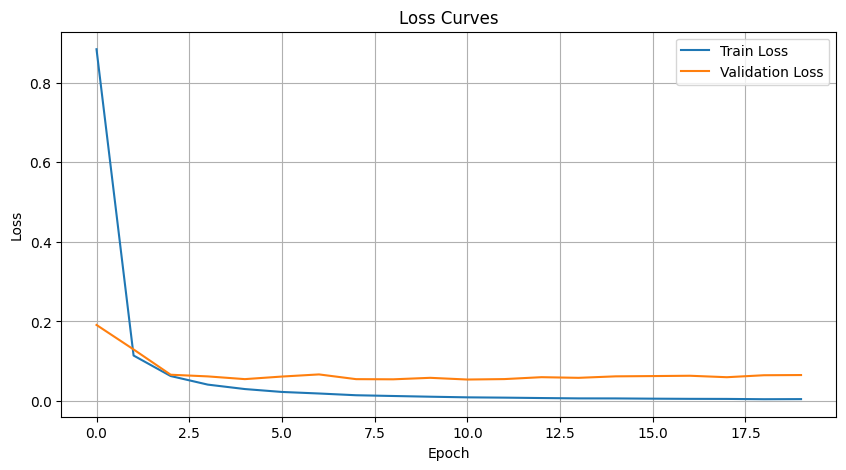

In [ ]:

# Prediction function
def predict(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            if batch is None:
                continue
                
            images = batch["images"].to(device)
            labels = batch["labels"].to(device)
            true_labels = batch["true_label"]
            input_lengths = batch["input_length"].to(device)
            label_lengths = batch["label_length"].to(device)
            
            outputs = model(images)
            outputs = outputs.log_softmax(2)
            outputs = outputs.permute(1, 0, 2)  # (time, batch, classes)
            
            # CTC decoding (simplified greedy decoding)
            _, predicted = torch.max(outputs, dim=2)
            predicted = predicted.permute(1, 0)  # (batch, time)
            
            for i in range(len(true_labels)):
                true_label = true_labels[i]
                pred_sequence = []
                prev_char = -1
                for t in range(predicted.size(1)):
                    char_idx = predicted[i, t].item()
                    if char_idx != prev_char and char_idx != BLANK_IDX:
                        pred_sequence.append(idx_to_char[char_idx])
                    prev_char = char_idx
                
                predicted_text = ''.join(pred_sequence)
                print(f"True Label: {true_label}, Predicted: {predicted_text}")

# Initialize and train
model = CRNN()
train_model(model, train_loader, test_loader, num_epochs=20)

# Save model
torch.save(model.state_dict(), "model.pth")

In [16]:

# Prediction function
def predict(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            if batch is None:
                continue
                
            images = batch["images"].to(device)
            labels = batch["labels"].to(device)
            true_labels = batch["true_label"]
            input_lengths = batch["input_length"].to(device)
            label_lengths = batch["label_length"].to(device)
            
            outputs = model(images)
            outputs = outputs.log_softmax(2)
            outputs = outputs.permute(1, 0, 2)  # (time, batch, classes)
            
            # CTC decoding (simplified greedy decoding)
            _, predicted = torch.max(outputs, dim=2)
            predicted = predicted.permute(1, 0)  # (batch, time)
            
            for i in range(len(true_labels)):
                true_label = true_labels[i]
                pred_sequence = []
                prev_char = -1
                for t in range(predicted.size(1)):
                    char_idx = predicted[i, t].item()
                    if char_idx != prev_char and char_idx != BLANK_IDX:
                        pred_sequence.append(idx_to_char[char_idx])
                    prev_char = char_idx
                
                predicted_text = ''.join(pred_sequence)
                # print(f"True Label: {true_label}, Predicted: {predicted_text}")

In [ ]:


# Run prediction
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth"))
predict(model, test_loader, device)


In [18]:
def evaluate_model(model, test_loader, device):
    correct_predictions = 0
    total_samples = 0
    
    with torch.no_grad():
        for batch in test_loader:
            if batch is None:
                continue
                
            images = batch["images"].to(device)
            true_labels = batch["true_label"]
            
            outputs = model(images)
            outputs = outputs.log_softmax(2)
            outputs = outputs.permute(1, 0, 2)
            
            _, predicted = torch.max(outputs, dim=2)
            predicted = predicted.permute(1, 0)
            
            for i in range(len(true_labels)):
                true_label = true_labels[i]
                pred_sequence = []
                prev_char = -1
                for t in range(predicted.size(1)):
                    char_idx = predicted[i, t].item()
                    if char_idx != prev_char and char_idx != BLANK_IDX:
                        pred_sequence.append(idx_to_char[char_idx])
                    prev_char = char_idx
                
                predicted_text = ''.join(pred_sequence)
                print(f"True Label: {true_label}, Predicted: {predicted_text}")
                
                if predicted_text == true_label:
                    correct_predictions += 1
                total_samples += 1
    
    if total_samples > 0:
        accuracy = (correct_predictions / total_samples) * 100
        print(f"\nEvaluation Results:")
        print(f"Correct Predictions: {correct_predictions}")
        print(f"Total Samples: {total_samples}")
        print(f"Accuracy: {accuracy:.2f}%")
    else:
        print("No valid samples found in the test dataset.")

# Run evaluation
evaluate_model(model, test_loader, device)

True Label: पड़ता, Predicted: पड़ता
True Label: था, Predicted: था
True Label: ।, Predicted: ।
True Label: के, Predicted: के
True Label: बीच, Predicted: बीच
True Label: एक, Predicted: एक
True Label: किवाड़, Predicted: किवाड़
True Label: था, Predicted: था
True Label: ।, Predicted: ।
True Label: वह, Predicted: वह
True Label: किवाड़, Predicted: किवाड़
True Label: खोलकर, Predicted: खोलकर
True Label: मेरे, Predicted: मेरे
True Label: कमरे, Predicted: कमरे
True Label: में, Predicted: में
True Label: आया, Predicted: आया
True Label: और, Predicted: और
True Label: जब, Predicted: जब
True Label: मैं, Predicted: मैं
True Label: होश, Predicted: होश
True Label: में, Predicted: में
True Label: आयी, Predicted: आयी
True Label: तो, Predicted: तो
True Label: दिल, Predicted: दिल
True Label: धड़कने, Predicted: धड़कने
True Label: लगा, Predicted: लगा
True Label: ।, Predicted: ।
True Label: अब, Predicted: अब
True Label: भी, Predicted: भी
True Label: मैंने, Predicted: मैंने
True Label: वही, Predicted: वही
True Label: कु